In [1]:
import sys
import os
from pathlib import Path
from collections import defaultdict
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torch


os.chdir('..')

from utils.model_factory import load_models
from utils.data_holder import DataHolder
from tasks.train_polynomial import TrainPolynomial
from distributions.mc_estimators.measure_valued import MVEstimator
from distributions.mc_estimators.pathwise import PathwiseEstimator
from distributions.mc_estimators.score_function import SFEstimator

_ = torch.empty(0)

plot_dir = Path('results')

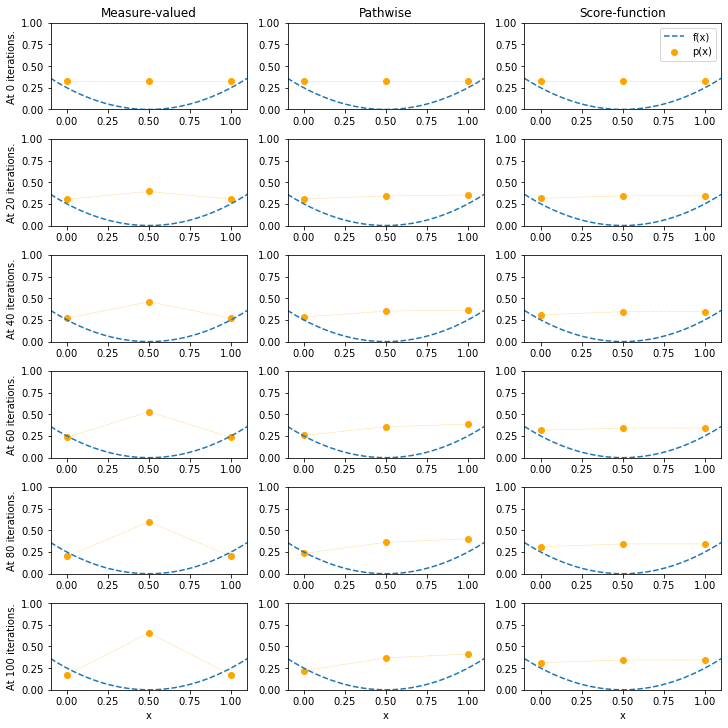

In [2]:
loss_space = torch.linspace(-0.1, 1.1, 200)
loss_fn = TrainPolynomial.quadratic(loss_space)

cat_3_models = load_models(Path('results', 'polynomial', 'cat_3'))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(cat_3_models) // 3, 3)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(PathwiseEstimator.name().capitalize())
axs[0,2].set_title(SFEstimator.name().capitalize())

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 20} iterations.") 

for path, model in cat_3_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations) // 20
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations, col]
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    axis.scatter(x, pdf, label="p(x)", color='orange')
    axis.plot(x, pdf, color='orange', linestyle='dotted', linewidth=.5)
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed')
    
    axis.set_ylim(0, 1)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'categoricals_parabola_3.pdf')
plt.show()

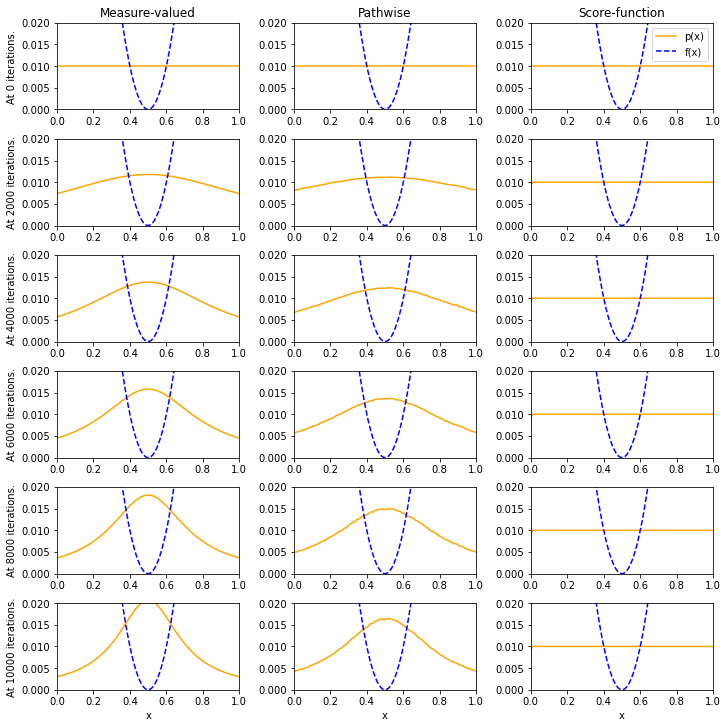

In [3]:
loss_space = torch.linspace(0, 1, 100)
loss_fn = TrainPolynomial.quadratic(loss_space)

cat_100_models = load_models(Path('results', 'polynomial', 'cat_100'))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(cat_100_models) // 3, 3)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(PathwiseEstimator.name().capitalize())
axs[0,2].set_title(SFEstimator.name().capitalize())

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 2000} iterations.") 

for path, model in cat_100_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations)
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations // 2000, col]
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(0.00, 0.02)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'categoricals_parabola_100.pdf')
plt.show()

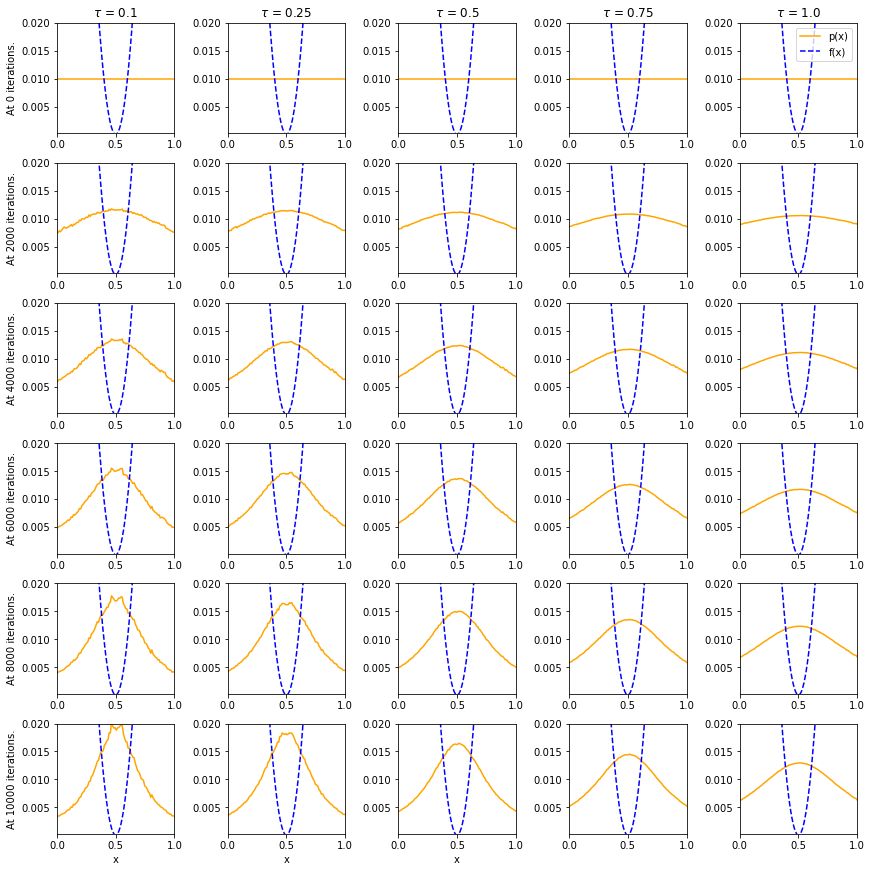

In [4]:
loss_space = torch.linspace(0, 1, 100)
loss_fn = TrainPolynomial.quadratic(loss_space)

cat_gumbel_temperatures_100_models = load_models(Path('results', 'polynomial', 'cat_gumbel_temperatures_100'))
temperatures = sorted({p.parent.parent.name for p, m in cat_gumbel_temperatures_100_models})
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
axs = fig.subplots(len(cat_gumbel_temperatures_100_models) // len(temperatures), len(temperatures))

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 2000} iterations.") 

for path, model in cat_gumbel_temperatures_100_models:
    temperature = path.parent.parent.name
    name, iterations = path.stem.split('_')
    row = int(iterations) // 2000
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    
    col = temperatures.index(temperature)
    axis = axs[row, col]
    if row == 0:
        axis.set_title(f"$\\tau$ = {temperature}")
    
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(0.00025, 0.02)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'gumbel_softmax_temperatures.pdf')
plt.show()

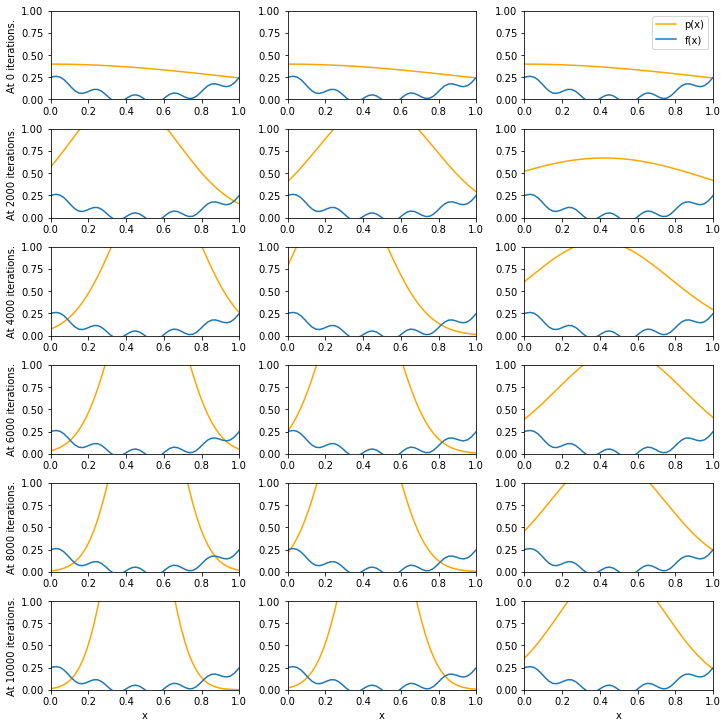

In [5]:
loss_space = torch.linspace(-3, 3, 300)
loss_fn = TrainPolynomial.quadratic_sinusoid(loss_space)

normal_models = load_models(Path('results', 'polynomial', 'normal'))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(normal_models) // 3, 3)

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 2000} iterations.") 

for path, model in normal_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations)
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations // 20, col]
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)")

    # Plot loss function
    x = torch.tensor(np.linspace(-3, 3, 200))
    
    axis.set_ylim(0, 1)
    axis.set_xlim(0, 1)

axs[0,-1].legend()
plt.show()

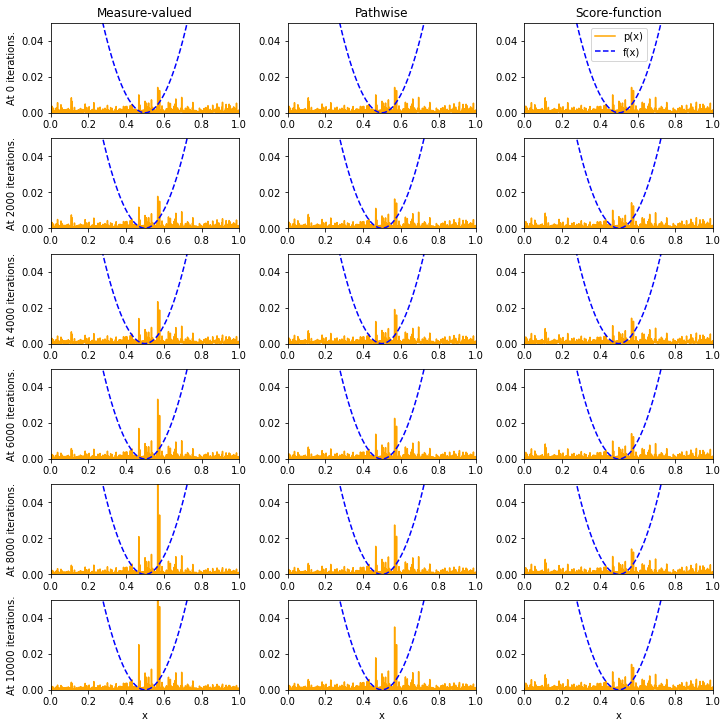

In [6]:
loss_space = torch.linspace(0, 1, 100)
loss_fn = TrainPolynomial.quadratic(loss_space)

cat_100_models = load_models(Path('results', 'polynomial', 'cat_100_random_init'))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(cat_100_models) // 3, 3)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(PathwiseEstimator.name().capitalize())
axs[0,2].set_title(SFEstimator.name().capitalize())

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 2000} iterations.") 

for path, model in cat_100_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations)
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations // 2000, col]
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(0.00, 0.05)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'categoricals_parabola_100_random_init.pdf')
plt.show()

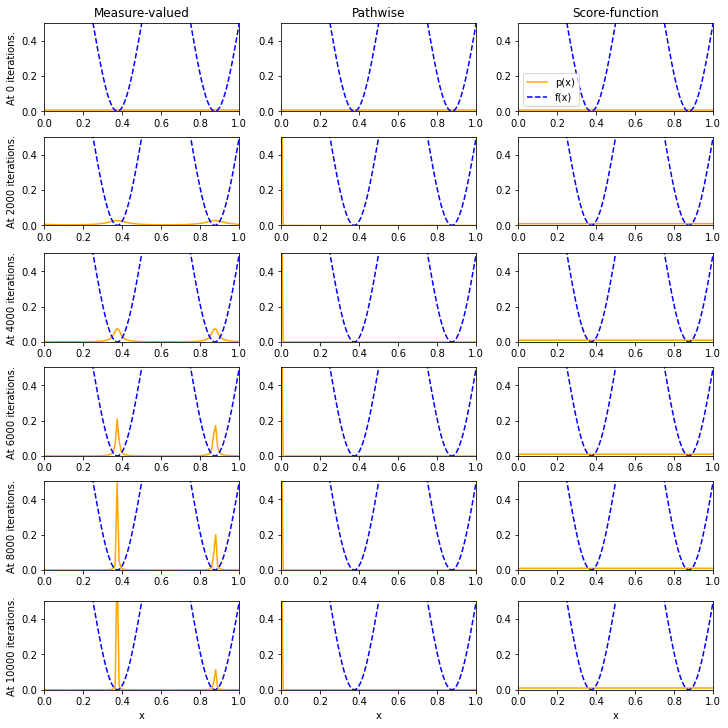

In [8]:
loss_space = torch.linspace(0, 1, 100)
loss_fn = TrainPolynomial.sinusoid(loss_space)

cat_100_models = load_models(Path('results', 'polynomial', 'cat_100_sinusoid'))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(cat_100_models) // 3, 3)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(PathwiseEstimator.name().capitalize())
axs[0,2].set_title(SFEstimator.name().capitalize())

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 2000} iterations.") 

for path, model in cat_100_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations)
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations // 2000, col]
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(0.00, 0.5)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'categoricals_sinusoid_100.pdf')
plt.show()

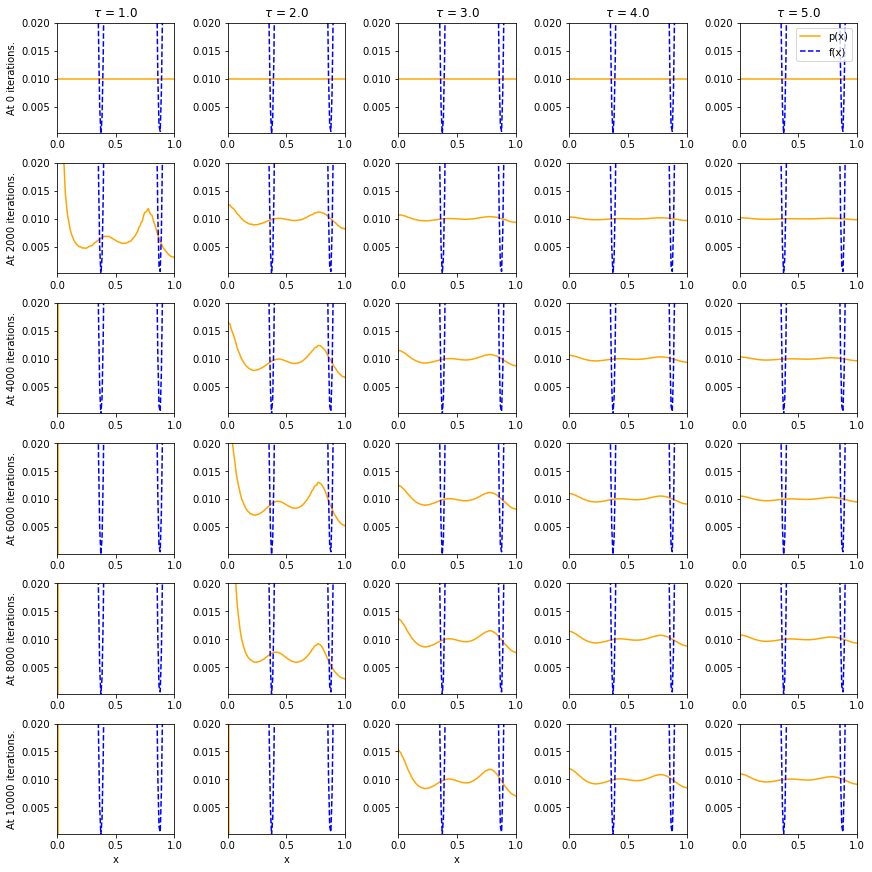

In [11]:
loss_space = torch.linspace(0, 1, 100)
loss_fn = TrainPolynomial.sinusoid(loss_space)

cat_gumbel_temperatures_100_models = load_models(Path('results', 'polynomial', 'cat_gumbel_temperatures_100_sinusoid'))
temperatures = sorted({p.parent.parent.name for p, m in cat_gumbel_temperatures_100_models})
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
axs = fig.subplots(len(cat_gumbel_temperatures_100_models) // len(temperatures), len(temperatures))

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 2000} iterations.") 

for path, model in cat_gumbel_temperatures_100_models:
    temperature = path.parent.parent.name
    name, iterations = path.stem.split('_')
    row = int(iterations) // 2000
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    
    col = temperatures.index(temperature)
    axis = axs[row, col]
    if row == 0:
        axis.set_title(f"$\\tau$ = {temperature}")
    
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(0.00025, 0.02)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'gumbel_softmax_temperatures_sinusoid.pdf')
plt.show()